In [1]:
import json
import pickle
import numpy as np
import logging
import os
import warnings
import joblib
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_fscore_support,
                             precision_score, recall_score, roc_auc_score)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import  StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

### Primer entrenamiento

con la base de datos sin scalamiento

PRIMERA RONDA DE ENTRENAMIENTO
Aqui escogeremos los 3 mejores modelos y trataremos de disminuir lasvaraibles y ver si se puede mejorar.

In [3]:
data = pd.read_csv('D:/Repositorio/Proyecto_ Venta de autos\Data_procecced/data_clean.csv')
data.head(2)

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,1,35,20000,0
1,681,1,40,43500,0


In [ ]:
def evaluate_model_with_feature_selection(model, X_train, X_test, y_train, y_test):
    """
    Evalúa un modelo de clasificación entrenado utilizando diferentes subconjuntos de características y calcula la precisión (accuracy).
    
    Parámetros:
    - model: Un modelo de clasificación ya entrenado (por ejemplo, RandomForestClassifier, DecisionTreeClassifier).
    - X_train: Datos de entrenamiento (DataFrame o array-like).
    - X_test: Datos de prueba (DataFrame o array-like).
    - y_train: Etiquetas de entrenamiento.
    - y_test: Etiquetas de prueba.
    
    Devuelve:
    - None. La función imprime y grafica los resultados.
    """
    
    feature_names = np.array(X_train.columns)  # Convertir a array de numpy de los nombres de las características

    # Obtener importancias de las características del modelo ya entrenado
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]

    # Visualización del progreso
    num_features = []
    accuracies = []
    selected_features_dict = {}  # Diccionario para almacenar las características seleccionadas

    for i in range(1, len(importances) + 1):
        selected_indices = sorted_indices[:i]
        selected_columns = X_train.columns[selected_indices]  # Extraer nombres de las columnas seleccionadas

        X_train_selected = X_train[selected_columns]
        X_test_selected = X_test[selected_columns]

        # Entrenar un nuevo modelo con las características seleccionadas
        model_selected = model.__class__(**model.get_params())  # Crear una instancia del mismo tipo de modelo con los mismos parámetros
        model_selected.fit(X_train_selected, y_train)
        y_pred = model_selected.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)

        num_features.append(i)
        accuracies.append(accuracy)
        selected_features_dict[i] = feature_names[selected_indices]  # Guardar los nombres de las características seleccionadas

    # Graficar Accuracy vs. Número de características seleccionadas
    plt.figure(figsize=(8, 4))
    plt.plot(num_features, accuracies, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Features for Feature Selection')
    plt.grid(True)
    plt.show()

    # Mostrar características seleccionadas para un número específico de características
    num_selected = 3  # Cambia este valor para ver diferentes números de características seleccionadas
    print(f"Características seleccionadas para {num_selected} características:")
    print(selected_features_dict.get(num_selected, 'Número de características seleccionado no está en el rango.'))


In [ ]:
dtc_top1 = DecisionTreeClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_depth=5,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=None,
    splitter='best'
)

dtc_top1.fit(X_train, y_train)

accuracy = dtc_top1.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.9100


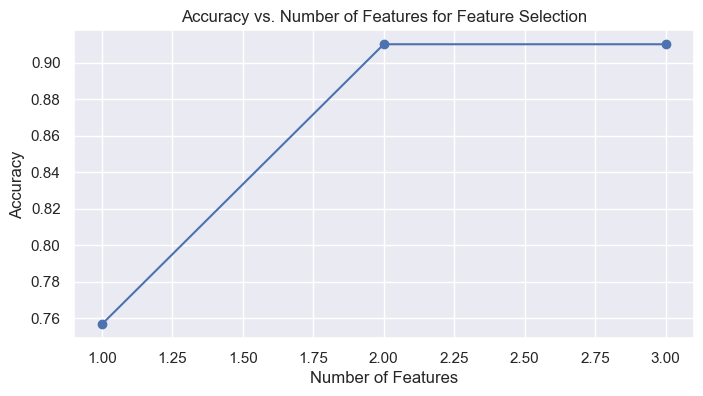

Características seleccionadas para 3 características:
['AnnualSalary' 'Age' 'Gender']


In [ ]:
evaluate_model_with_feature_selection(dtc_top1, X_train, X_test, y_train, y_test)

In [ ]:
rf_top2 = RandomForestClassifier(
    class_weight='balanced',  
    criterion='entropy',      
    max_depth=None, 
    max_features='sqrt',
    min_samples_leaf=2, 
    min_samples_split=10,
    n_estimators=200, 
    n_jobs=-1
)
rf_top2.fit(X_train, y_train)

accuracy = rf_top2.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.9000


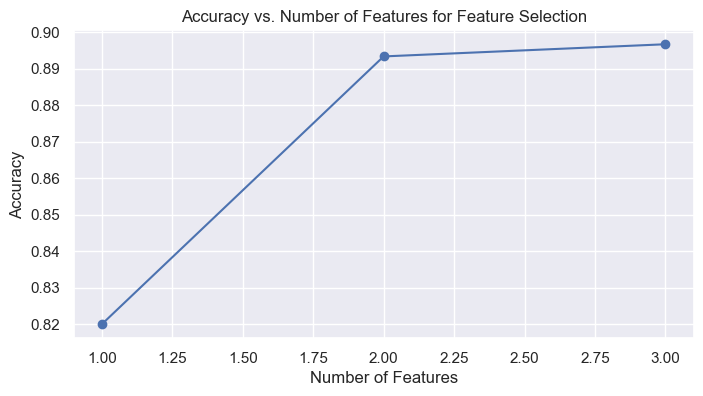

Características seleccionadas para 3 características:
['Age' 'AnnualSalary' 'Gender']


In [ ]:
evaluate_model_with_feature_selection(rf_top2, X_train, X_test, y_train, y_test)

In [ ]:
rf_top3 = RandomForestClassifier(max_depth=2,random_state=42)
rf_top3.fit(X_train, y_train)
accuracy = rf_top3.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.8900


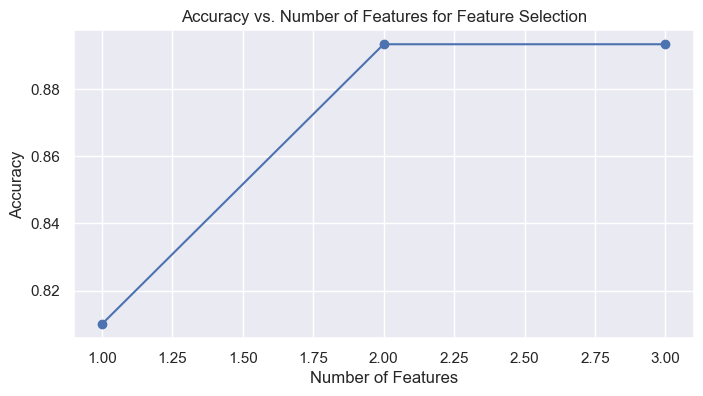

Características seleccionadas para 3 características:
['Age' 'AnnualSalary' 'Gender']


In [ ]:
evaluate_model_with_feature_selection(rf_top3, X_train, X_test, y_train, y_test)

SEGUNDA RONDA DE ENTRENAMIENTO
Aqui escogeremos los 3 mejores modelos y trataremos de disminuir lasvaraibles y ver si se puede mejorar.

In [ ]:
features = data.drop(columns=['Purchased'])  # Eliminar la columna de destino
target = data['Purchased']  # Guardar la columna de destino

# Escalar las características
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convertir los resultados escalados a un DataFrame con los mismos nombres de columnas
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

# Combinar las características escaladas con la columna de destino
df_scaled = pd.concat([scaled_features_df, target], axis=1)

In [ ]:
rf_top1scaled = RandomForestClassifier(
    criterion='gini', 
    max_depth= 10, 
    max_features= None, 
    min_samples_leaf= 1, 
    min_samples_split= 10, 
    n_estimators= 300, 
    n_jobs= -1
)
rf_top1scaled.fit(X_train, y_train)

accuracy = rf_top1scaled.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.9067


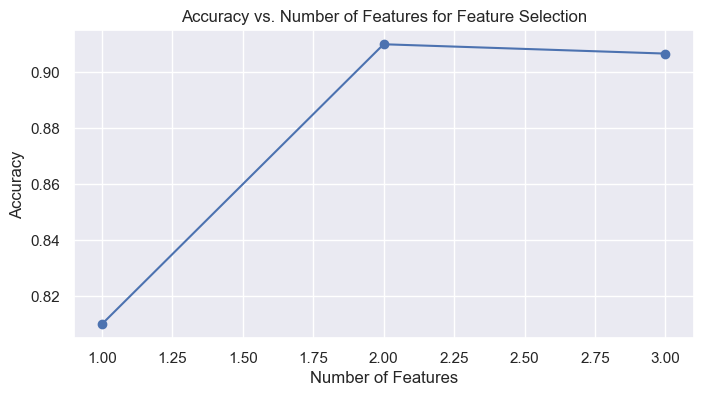

Características seleccionadas para 3 características:
['Age' 'AnnualSalary' 'Gender']


In [ ]:
evaluate_model_with_feature_selection(rf_top1scaled, X_train, X_test, y_train, y_test)

In [ ]:
svc_top2scaled = SVC(
    probability=True,
    C= 10.0, 
    class_weight = None, 
    gamma='scale', 
    kernel= 'rbf', 
    max_iter= 200, 
    shrinking= True, 
    tol= 0.001
)
svc_top2scaled.fit(X_train, y_train)

accuracy = svc_top2scaled.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.9067


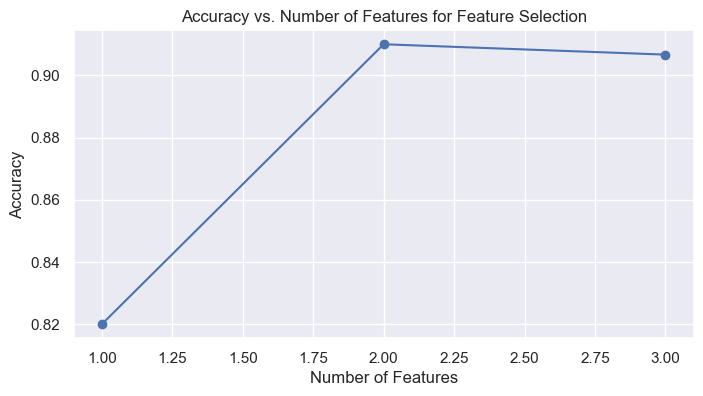

Características seleccionadas para 3 características:
['Age' 'AnnualSalary' 'Gender']


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_with_feature_selection(model, X_train, X_test, y_train, y_test):
    """
    Evalúa un modelo de clasificación entrenado utilizando diferentes subconjuntos de características y calcula la precisión (accuracy).
    
    Parámetros:
    - model: Un modelo de clasificación ya entrenado (por ejemplo, SVC, RandomForestClassifier, DecisionTreeClassifier).
    - X_train: Datos de entrenamiento (DataFrame o array-like).
    - X_test: Datos de prueba (DataFrame o array-like).
    - y_train: Etiquetas de entrenamiento.
    - y_test: Etiquetas de prueba.
    
    Devuelve:
    - None. La función imprime y grafica los resultados.
    """
    
    feature_names = np.array(X_train.columns)  # Convertir a array de numpy de los nombres de las características

    # Usar un modelo base que sea compatible con RFE para seleccionar características
    base_estimator = LogisticRegression(max_iter=1000)  # Puedes usar LogisticRegression o LinearSVC
    selector = RFE(estimator=base_estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X_train, y_train)
    sorted_indices = np.argsort(selector.ranking_)

    # Visualización del progreso
    num_features = []
    accuracies = []
    selected_features_dict = {}  # Diccionario para almacenar las características seleccionadas

    for i in range(1, len(sorted_indices) + 1):
        selected_indices = sorted_indices[:i]
        selected_columns = X_train.columns[selected_indices]  # Extraer nombres de las columnas seleccionadas

        X_train_selected = X_train[selected_columns]
        X_test_selected = X_test[selected_columns]

        # Entrenar un nuevo modelo con las características seleccionadas
        model_selected = model.__class__(**model.get_params())  # Crear una instancia del mismo tipo de modelo con los mismos parámetros
        model_selected.fit(X_train_selected, y_train)
        y_pred = model_selected.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)

        num_features.append(i)
        accuracies.append(accuracy)
        selected_features_dict[i] = feature_names[selected_indices]  # Guardar los nombres de las características seleccionadas

    # Graficar Accuracy vs. Número de características seleccionadas
    plt.figure(figsize=(8, 4))
    plt.plot(num_features, accuracies, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Features for Feature Selection')
    plt.grid(True)
    plt.show()

    # Mostrar características seleccionadas para un número específico de características
    num_selected = 3  # Cambia este valor para ver diferentes números de características seleccionadas
    print(f"Características seleccionadas para {num_selected} características:")
    print(selected_features_dict.get(num_selected, 'Número de características seleccionado no está en el rango.'))

# Ejemplo de uso con SVC
svc_top2scaled = SVC(
    probability=True,
    C= 10.0, 
    class_weight = None, 
    gamma='scale', 
    kernel= 'rbf', 
    max_iter= 200, 
    shrinking= True, 
    tol= 0.001
)
svc_top2scaled.fit(X_train, y_train)

evaluate_model_with_feature_selection(svc_top2scaled, X_train, X_test, y_train, y_test)


In [ ]:
knn_top3scaled = KNeighborsClassifier()
knn_top3scaled.fit(X_train, y_train)

accuracy = knn_top3scaled.score(X_test, y_test)
print(f"Accuracy del modelo en los datos de prueba: {accuracy:.4f}")

Accuracy del modelo en los datos de prueba: 0.9100


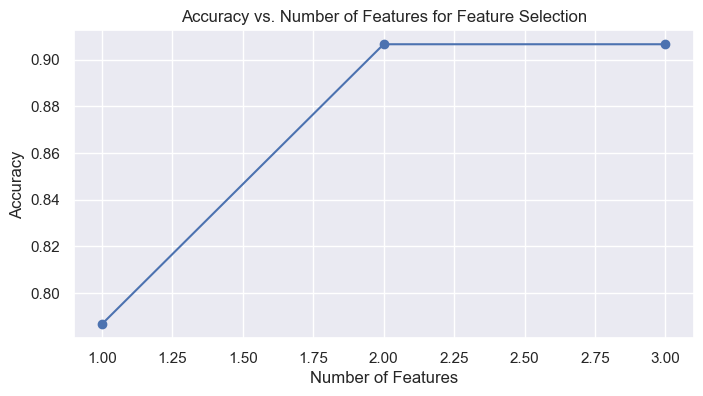

Características seleccionadas para 3 características:
['Age' 'AnnualSalary' 'Gender']


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_with_feature_selection_knn(model, X_train, X_test, y_train, y_test):
    """
    Evalúa un modelo de clasificación (KNeighborsClassifier) utilizando diferentes subconjuntos de características seleccionados con RFE.
    
    Parámetros:
    - model: Un modelo de clasificación ya entrenado (en este caso, KNeighborsClassifier).
    - X_train: Datos de entrenamiento (DataFrame o array-like).
    - X_test: Datos de prueba (DataFrame o array-like).
    - y_train: Etiquetas de entrenamiento.
    - y_test: Etiquetas de prueba.
    
    Devuelve:
    - None. La función imprime y grafica los resultados.
    """
    
    feature_names = np.array(X_train.columns)  # Convertir a array de numpy de los nombres de las características

    # Usar un modelo base que sea compatible con RFE para seleccionar características
    base_estimator = LogisticRegression(max_iter=1000)  # Puedes usar LogisticRegression o LinearSVC
    selector = RFE(estimator=base_estimator, n_features_to_select=1, step=1)
    selector = selector.fit(X_train, y_train)
    sorted_indices = np.argsort(selector.ranking_)

    # Visualización del progreso
    num_features = []
    accuracies = []
    selected_features_dict = {}  # Diccionario para almacenar las características seleccionadas

    for i in range(1, len(sorted_indices) + 1):
        selected_indices = sorted_indices[:i]
        selected_columns = X_train.columns[selected_indices]  # Extraer nombres de las columnas seleccionadas

        X_train_selected = X_train[selected_columns]
        X_test_selected = X_test[selected_columns]

        # Entrenar un nuevo modelo KNN con las características seleccionadas
        model_selected = model.__class__(**model.get_params())  # Crear una instancia del mismo tipo de modelo con los mismos parámetros
        model_selected.fit(X_train_selected, y_train)
        y_pred = model_selected.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)

        num_features.append(i)
        accuracies.append(accuracy)
        selected_features_dict[i] = feature_names[selected_indices]  # Guardar los nombres de las características seleccionadas

    # Graficar Accuracy vs. Número de características seleccionadas
    plt.figure(figsize=(8, 4))
    plt.plot(num_features, accuracies, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Features for Feature Selection')
    plt.grid(True)
    plt.show()

    # Mostrar características seleccionadas para un número específico de características
    num_selected = 3  # Cambia este valor para ver diferentes números de características seleccionadas
    print(f"Características seleccionadas para {num_selected} características:")
    print(selected_features_dict.get(num_selected, 'Número de características seleccionado no está en el rango.'))

# Ejemplo de uso con KNeighborsClassifier
knn_top3scaled = KNeighborsClassifier(n_neighbors=3)  # Puedes ajustar los parámetros según sea necesario
knn_top3scaled.fit(X_train, y_train)

evaluate_model_with_feature_selection_knn(knn_top3scaled, X_train, X_test, y_train, y_test)
